In [85]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
from sklearn.decomposition import PCA
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

# Data load
Hand cleaned to removed duplicates.  

In [243]:
cleansed=load_amihud_markets_price()
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

# PCA Analysis


In [361]:
ind=amihud['BMF-ARABICA COFFEE'].dropna().index
temp=amihud.ix[ind].dropna(axis=1)

In [362]:
x=temp.max()
x.sort()
removed_noise=x.tail(3).index
temp=temp[temp.columns-removed_noise]

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  from IPython.kernel.zmq import kernelapp as app
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()


In [363]:
ct=amihud.count()
ct.sort()
ct[ct>200].head()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  from IPython.kernel.zmq import kernelapp as app


BMF-ARABICA COFFEE            203
BRL/USD                       205
UK Natural Gas                205
CME-3 MTH EURODOLLAR COMP.    205
EuroSwiss                     205
dtype: int64

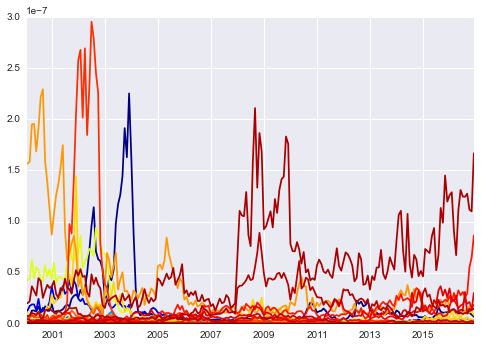

In [364]:
temp.plot(colormap='jet',legend=False)

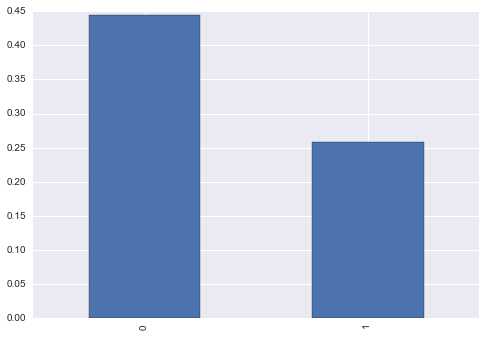

In [365]:
components=2
pca=PCA(n_components=components)
pca.fit(temp)
pd.Series(pca.explained_variance_ratio_).plot(kind='bar')

In [366]:
pca.explained_variance_ratio_

array([ 0.44408202,  0.25786202])

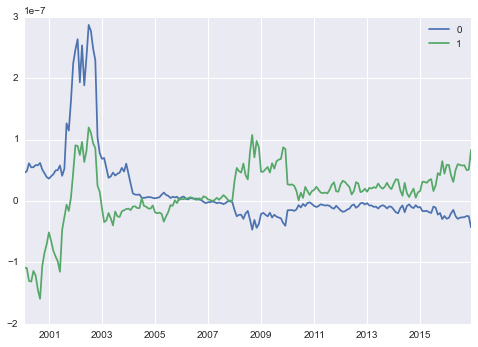

In [367]:
factor_rts=pd.DataFrame()
for i in range(0,components,1):
    q=pca.components_[i]
    factor_rts[i]=(q*temp.dropna()).sum(axis=1)
factor_rts.plot()

In [368]:
factor_rts
ind=factor_rts.index
PS=pd.read_csv('PS.csv',parse_dates=[0]).set_index('Month').resample(rule='m',how='last')
VAR_PCA=pd.read_csv('market_liquidity_factors.csv',index_col=0,parse_dates=[0])
VAR_PCA['Pastor and Stambaugh (2003)']=PS['Traded liquidity factor']
VAR_PCA['PCA Factor']=factor_rts[0]

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  app.launch_new_instance()


In [369]:
central_banks_asset=pd.DataFrame()
central_banks_asset['ECB']=pd.read_csv('ECBASSETS.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).ECBASSETS.resample(rule='m',how='last')
central_banks_asset['BOJ']=pd.read_csv('JPNASSETS.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).JPNASSETS.resample(rule='m',how='last') 
central_banks_asset['Fed']=pd.read_csv('WALCL.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).WALCL.resample(rule='m',how='last')
fx=pd.DataFrame()
fx['BOJ']=quandl.get('CURRFX/USDJPY',authtoken=token).resample(rule='m',how='last').Rate/100
fx['ECB']=quandl.get('CURRFX/USDEUR',authtoken=token).resample(rule='m',how='last').Rate
fx['Fed']=1
VAR_PCA['Central Bank Assets']=(central_banks_asset/fx).dropna(how='all').sum(axis=1).resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: FutureWarning: how in .resample() is deprecated
the 

In [370]:
temp=VAR_PCA.ix[ind]

In [371]:
temp.columns
col=[ u'LIBOR', u'FinancialStress','Central Bank Assets',u'PCA Factor']

In [372]:
import statsmodels.tsa.vector_ar.var_model as VAR
res = VAR.VAR(endog=temp[col].dropna()).fit()
print res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 26, Aug, 2017
Time:                     11:40:35
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -14.9512
Nobs:                     190.000    HQIC:                  -15.1546
Log likelihood:           394.444    FPE:                2.28215e-07
AIC:                     -15.2930    Det(Omega_mle):     2.05693e-07
--------------------------------------------------------------------
Results for equation LIBOR
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.678165         0.201404            3.367           0.001
L1.LIBOR                       0.867446         0.033322           26.032           0.000
L1.FinancialStress      

In [373]:
model = VAR.VAR(endog=temp[col].dropna())
model.select_order(24)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -5.829       -5.754     0.002942       -5.798
1        -17.39       -17.01    2.811e-08       -17.24
2        -18.38      -17.71*    1.038e-08      -18.11*
3        -18.48       -17.51    9.465e-09       -18.08
4        -18.60       -17.33    8.389e-09       -18.08
5       -18.68*       -17.12   7.731e-09*       -18.05
6        -18.61       -16.75    8.330e-09       -17.85
7        -15.78       -13.61    1.426e-07       -14.90
8        -12.86       -10.39    2.663e-06       -11.86
9        -13.43       -10.67    1.514e-06       -12.31
10       -14.55       -11.48    5.017e-07       -13.30
11       -14.27       -10.90    6.734e-07       -12.90
12       -13.63       -9.975    1.286e-06       -12.15
13       -13.57       -9.609    1.404e-06       -11.96
14       -14.43       -10.17    6.083e-07       -12.70
15       -

{'aic': 5, 'bic': 2, 'fpe': 5, 'hqic': 2}

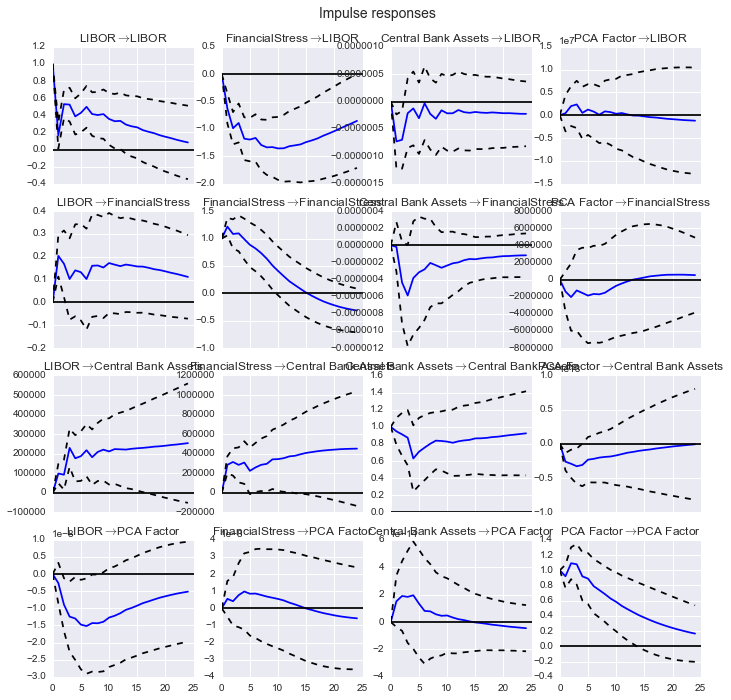

In [374]:
resaic = model.fit(maxlags=24,ic='aic')
irf=resaic.irf(24)
sns.set(font_scale=1)
irf.plot()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


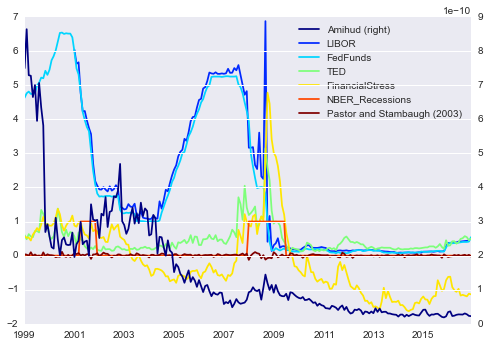

In [375]:
PS=pd.read_csv('PS.csv',parse_dates=[0]).set_index('Month').resample(rule='m',how='last')
factors=pd.read_csv('market_liquidity_factors.csv',index_col=0,parse_dates=[0])
factors['Pastor and Stambaugh (2003)']=PS['Traded liquidity factor']
factors.plot(secondary_y='Amihud',colormap='jet')

In [353]:
for i in range(0,components,1):
    factors['PCA Factor '+ str(i+1)]=factor_rts[i]

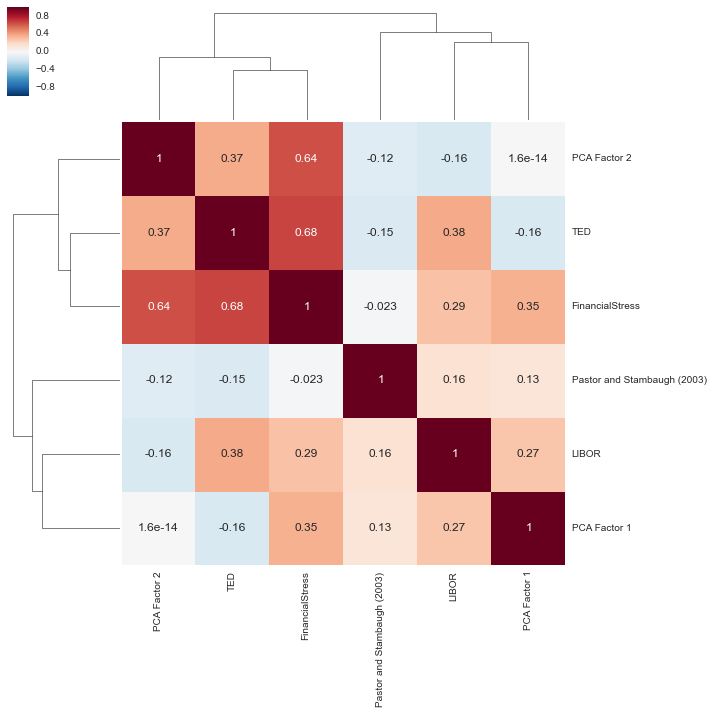

In [354]:
f=[u'LIBOR', u'TED', u'FinancialStress',
        u'Pastor and Stambaugh (2003)', u'PCA Factor 1',
       u'PCA Factor 2']
sns.clustermap(factors[f].corr(),annot=True)

In [355]:
col=[u'Amihud', u'LIBOR', u'FinancialStress','Central Bank Assets']
factors['Intercept']=1
en=factors.dropna()

In [356]:
RES=pd.DataFrame()
for factor in f:
    res=sm.OLS(en['PCA Factor 1']*1e7,en[['Intercept',factor]]).fit()
    s=pd.Series()
    s['Intercept']=res.params.Intercept
    s['Intercept Tstat']=res.tvalues.Intercept
    s['Factor']=res.params[factor]
    s['Factor' + ' Tstat']=res.tvalues[factor]    
    s['R^2']=res.rsquared_adj
    RES[factor]=s   
RES.round(2)

,LIBOR,TED,FinancialStress,Pastor and Stambaugh (2003),PCA Factor 1,PCA Factor 2
Intercept,-0.03,0.10,0.05,0.03,-0.000000e+00,0.04
Intercept Tstat,-1.10,3.94,2.89,1.56,-5.550000e+00,1.48
Factor,0.04,-0.15,0.07,1.13,1.000000e+07,-455322.25
Factor Tstat,3.92,-3.59,4.01,2.31,3.539689e+16,-0.35
R^2,0.07,0.06,0.07,0.02,1.000000e+00,-0.00


In [357]:
print RES.round(2).to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &  LIBOR &   TED &  FinancialStress &  Pastor and Stambaugh (2003) &  PCA Factor 1 &  PCA Factor 2 \\
\midrule
Intercept       &  -0.03 &  0.10 &             0.05 &                         0.03 & -0.000000e+00 &          0.04 \\
Intercept Tstat &  -1.10 &  3.94 &             2.89 &                         1.56 & -5.550000e+00 &          1.48 \\
Factor          &   0.04 & -0.15 &             0.07 &                         1.13 &  1.000000e+07 &    -455322.25 \\
Factor Tstat    &   3.92 & -3.59 &             4.01 &                         2.31 &  3.539689e+16 &         -0.35 \\
R\textasciicircum2             &   0.07 &  0.06 &             0.07 &                         0.02 &  1.000000e+00 &         -0.00 \\
\bottomrule
\end{tabular}



In [358]:
RES=pd.DataFrame()
for factor in f:
    res=sm.OLS(en['PCA Factor 2']*1e7,en[['Intercept',factor]]).fit()
    s=pd.Series()
    s['Intercept']=res.params.Intercept
    s['Intercept Tstat']=res.tvalues.Intercept
    s['Factor']=res.params[factor]
    s['Factor' + ' Tstat']=res.tvalues[factor]    
    s['R^2']=res.rsquared_adj
    RES[factor]=s   
RES.round(2)

,LIBOR,TED,FinancialStress,Pastor and Stambaugh (2003),PCA Factor 1,PCA Factor 2
Intercept,0.20,0.12,0.20,0.18,0.18,-0.000000e+00
Intercept Tstat,14.42,9.00,24.74,17.29,16.94,-3.890000e+00
Factor,-0.01,0.13,0.09,-0.53,-145973.99,1.000000e+07
Factor Tstat,-2.24,5.65,11.92,-1.90,-0.35,3.060565e+16
R^2,0.02,0.14,0.43,0.01,-0.00,1.000000e+00


In [359]:
print RES.round(2).to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &  LIBOR &   TED &  FinancialStress &  Pastor and Stambaugh (2003) &  PCA Factor 1 &  PCA Factor 2 \\
\midrule
Intercept       &   0.20 &  0.12 &             0.20 &                         0.18 &          0.18 & -0.000000e+00 \\
Intercept Tstat &  14.42 &  9.00 &            24.74 &                        17.29 &         16.94 & -3.890000e+00 \\
Factor          &  -0.01 &  0.13 &             0.09 &                        -0.53 &    -145973.99 &  1.000000e+07 \\
Factor Tstat    &  -2.24 &  5.65 &            11.92 &                        -1.90 &         -0.35 &  3.060565e+16 \\
R\textasciicircum2             &   0.02 &  0.14 &             0.43 &                         0.01 &         -0.00 &  1.000000e+00 \\
\bottomrule
\end{tabular}

